In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings #https://www.geeksforgeeks.org/warnings-in-python/
import os
# from tqdm import tqdm #https://www.geeksforgeeks.org/python-how-to-make-a-terminal-progress-bar-using-tqdm/
import glob
import pydicom #https://pydicom.github.io/pydicom/stable/old/working_with_pixel_data.html
import cv2
from skimage import measure
import plotly.graph_objects as go

train_df = pd.read_csv('../data/train.csv')

train_df = train_df.drop_duplicates()

In [2]:
display(train_df.shape)
display(train_df.head())

(1975, 26)

study_id spinal_canal_stenosis_l1_l2 spinal_canal_stenosis_l2_l3  \
0   4003253                 Normal/Mild                 Normal/Mild   
1   4646740                 Normal/Mild                 Normal/Mild   
2   7143189                 Normal/Mild                 Normal/Mild   
3   8785691                 Normal/Mild                 Normal/Mild   
4  10728036                 Normal/Mild                 Normal/Mild   

  spinal_canal_stenosis_l3_l4 spinal_canal_stenosis_l4_l5  \
0                 Normal/Mild                 Normal/Mild   
1                    Moderate                      Severe   
2                 Normal/Mild                 Normal/Mild   
3                 Normal/Mild                 Normal/Mild   
4                 Normal/Mild                 Normal/Mild   

  spinal_canal_stenosis_l5_s1 left_neural_foraminal_narrowing_l1_l2  \
0                 Normal/Mild                           Normal/Mild   
1                 Normal/Mild                           Normal/Mild   
2                 Normal/Mild                           Normal/Mild   
3                 Normal/Mild                           Normal/Mild   
4                 Normal/Mild                           Normal/Mild   

  left_neural_foraminal_narrowing_l2_l3 left_neural_foraminal_narrowing_l3_l4  \
0                           Normal/Mild                           Normal/Mild   
1                           Normal/Mild                           Normal/Mild   
2                           Normal/Mild                           Normal/Mild   
3                           Normal/Mild                           Normal/Mild   
4                           Normal/Mild                           Normal/Mild   

  left_neural_foraminal_narrowing_l4_l5  ... left_subarticular_stenosis_l1_l2  \
0                              Moderate  ...                      Normal/Mild   
1                              Moderate  ...                      Normal/Mild   
2                           Normal/Mild  ...                      Normal/Mild   
3                              Moderate  ...                      Normal/Mild   
4                           Normal/Mild  ...                      Normal/Mild   

  left_subarticular_stenosis_l2_l3 left_subarticular_stenosis_l3_l4  \
0                      Normal/Mild                      Normal/Mild   
1                      Normal/Mild                      Normal/Mild   
2                      Normal/Mild                      Normal/Mild   
3                      Normal/Mild                      Normal/Mild   
4                      Normal/Mild                      Normal/Mild   

  left_subarticular_stenosis_l4_l5 left_subarticular_stenosis_l5_s1  \
0                         Moderate                      Normal/Mild   
1                           Severe                      Normal/Mild   
2                      Normal/Mild                      Normal/Mild   
3                      Normal/Mild                      Normal/Mild   
4                      Normal/Mild                      Normal/Mild   

  right_subarticular_stenosis_l1_l2 right_subarticular_stenosis_l2_l3  \
0                       Normal/Mild                       Normal/Mild   
1                       Normal/Mild                          Moderate   
2                       Normal/Mild                       Normal/Mild   
3                       Normal/Mild                       Normal/Mild   
4                       Normal/Mild                       Normal/Mild   

  right_subarticular_stenosis_l3_l4 right_subarticular_stenosis_l4_l5  \
0                       Normal/Mild                       Normal/Mild   
1                          Moderate                          Moderate   
2                       Normal/Mild                       Normal/Mild   
3                       Normal/Mild                       Normal/Mild   
4                       Normal/Mild                          Moderate   

  right_subarticular_stenosis_l5_s1  
0                       Normal/Mild  


In [3]:
display(train_df.info(verbose = True, show_counts = True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975 entries, 0 to 1974
Data columns (total 26 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   study_id                                1975 non-null   int64 
 1   spinal_canal_stenosis_l1_l2             1974 non-null   object
 2   spinal_canal_stenosis_l2_l3             1974 non-null   object
 3   spinal_canal_stenosis_l3_l4             1974 non-null   object
 4   spinal_canal_stenosis_l4_l5             1974 non-null   object
 5   spinal_canal_stenosis_l5_s1             1974 non-null   object
 6   left_neural_foraminal_narrowing_l1_l2   1973 non-null   object
 7   left_neural_foraminal_narrowing_l2_l3   1973 non-null   object
 8   left_neural_foraminal_narrowing_l3_l4   1973 non-null   object
 9   left_neural_foraminal_narrowing_l4_l5   1973 non-null   object
 10  left_neural_foraminal_narrowing_l5_s1   1973 non-null   object
 11  righ

None

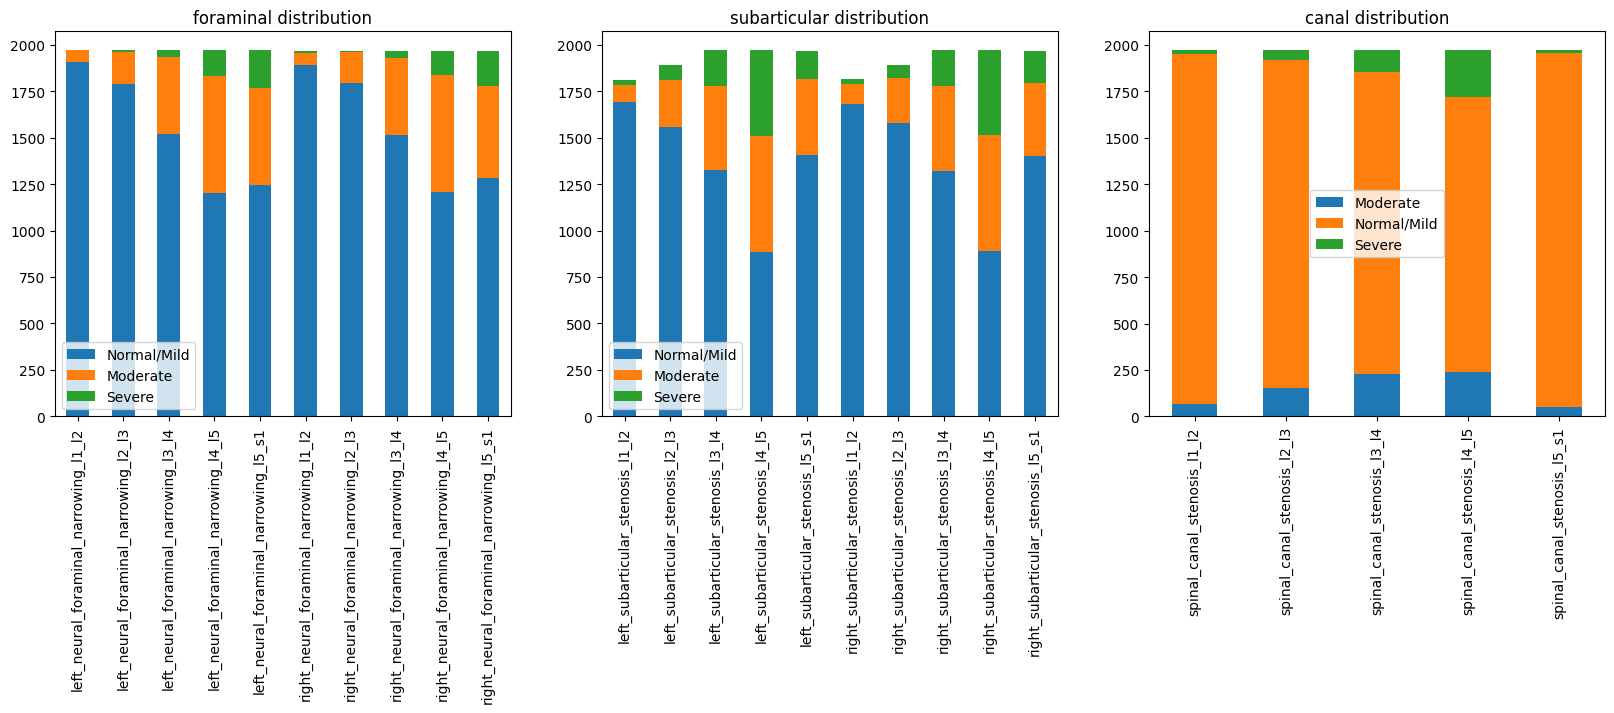

In [4]:
# https://www.kaggle.com/code/abhinavsuri/anatomy-image-visualization-overview-rsna-raids/notebook
figure, axis = plt.subplots(1, 3, figsize=(20,5)) #https://www.geeksforgeeks.org/matplotlib-pyplot-subplots-in-python/
for idx, diag in enumerate(['foraminal', 'subarticular', 'canal']): #https://www.geeksforgeeks.org/enumerate-in-python/
    diagnosis = list(filter(lambda x: x.find(diag) > -1, train_df.columns)) #https://www.geeksforgeeks.org/filter-in-python/
    # display(diagnosis)
    dummy_df = train_df[diagnosis]
    with warnings.catch_warnings(): #https://www.geeksforgeeks.org/warnings-in-python/
        warnings.simplefilter(action='ignore', category=FutureWarning)
        count_df = dummy_df.apply(pd.value_counts).fillna(0).T
    # count_df = dummy_df.apply(pd.value_counts).fillna(0).T
    # display(count_df)
    count_df.plot(kind='bar', stacked=True, ax=axis[idx])
    axis[idx].set_title(f'{diag} distribution')

In [5]:
train_df = pd.read_csv('../data/train.csv')
desc_df = pd.read_csv('../data/train_series_descriptions.csv')
coor_df = pd.read_csv('../data/train_label_coordinates.csv')

df = pd.merge(left=coor_df, right=train_df, how='left', on='study_id').reset_index(drop=True)
df = pd.merge(left=df, right=desc_df, how='left', on=['study_id', 'series_id']).reset_index(drop=True)
display(df.head(3))

study_id  series_id  instance_number              condition  level  \
0   4003253  702807833                8  Spinal Canal Stenosis  L1/L2   
1   4003253  702807833                8  Spinal Canal Stenosis  L2/L3   
2   4003253  702807833                8  Spinal Canal Stenosis  L3/L4   

            x           y spinal_canal_stenosis_l1_l2  \
0  322.831858  227.964602                 Normal/Mild   
1  320.571429  295.714286                 Normal/Mild   
2  323.030303  371.818182                 Normal/Mild   

  spinal_canal_stenosis_l2_l3 spinal_canal_stenosis_l3_l4  ...  \
0                 Normal/Mild                 Normal/Mild  ...   
1                 Normal/Mild                 Normal/Mild  ...   
2                 Normal/Mild                 Normal/Mild  ...   

  left_subarticular_stenosis_l2_l3 left_subarticular_stenosis_l3_l4  \
0                      Normal/Mild                      Normal/Mild   
1                      Normal/Mild                      Normal/Mild   
2                      Normal/Mild                      Normal/Mild   

  left_subarticular_stenosis_l4_l5 left_subarticular_stenosis_l5_s1  \
0                         Moderate                      Normal/Mild   
1                         Moderate                      Normal/Mild   
2                         Moderate                      Normal/Mild   

  right_subarticular_stenosis_l1_l2 right_subarticular_stenosis_l2_l3  \
0                       Normal/Mild                       Normal/Mild   
1                       Normal/Mild                       Normal/Mild   
2                       Normal/Mild                       Normal/Mild   

  right_subarticular_stenosis_l3_l4 right_subarticular_stenosis_l4_l5  \
0                       Normal/Mild                       Normal/Mild   
1                       Normal/Mild                       Normal/Mild   
2                       Normal/Mild                       Normal/Mild   

  right_subarticular_stenosis_l5_s1 series_description  
0                       Normal/Mild   Sagittal T2/STIR  
1                       Normal/Mild   Sagittal T2/STIR  
2                       Normal/Mild   Sagittal T2/STIR  

[3 rows x 33 columns]

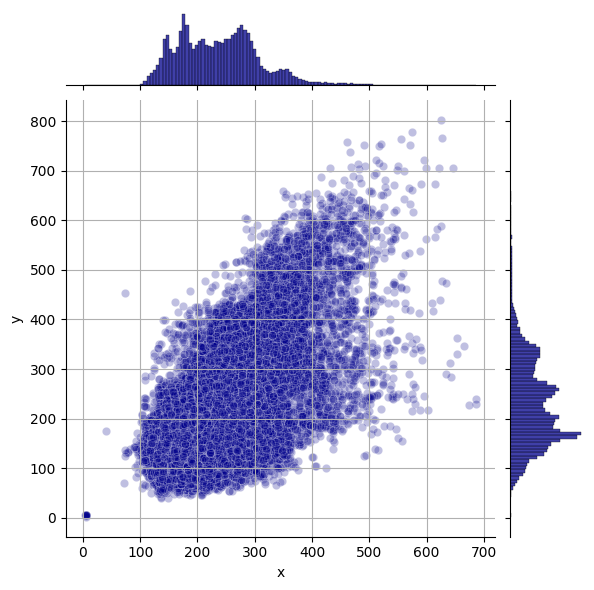

In [6]:
# https://www.kaggle.com/code/docxian/rsna-2024-lumbar-spine-explore-training-data
sns.jointplot(data=df, x='x', y='y', 
              color='darkblue', alpha=0.25)
plt.grid()
plt.show()

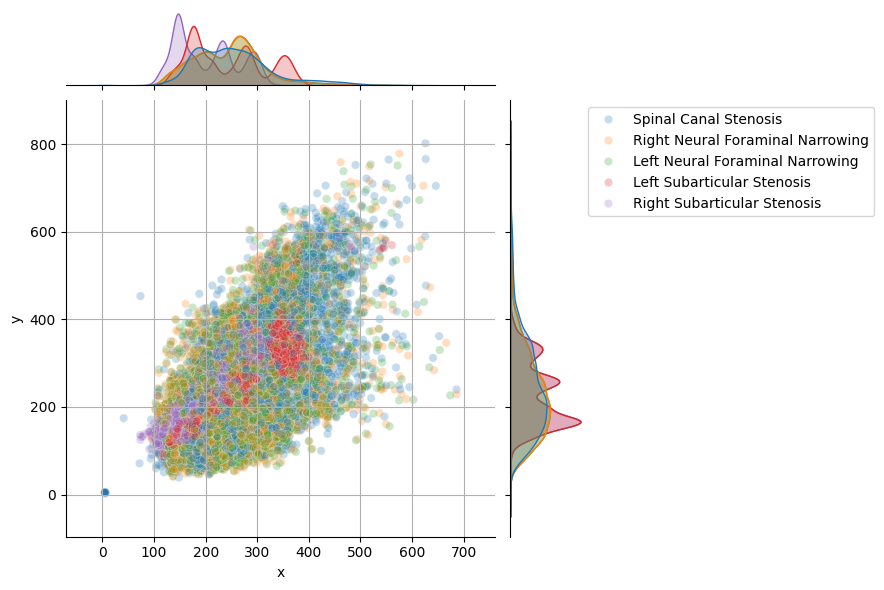

In [7]:
sns.jointplot(data=df, x='x', y='y', 
              hue='condition', alpha=0.25)
plt.legend(bbox_to_anchor=(1.2,1), loc=2)
plt.grid()
plt.show()

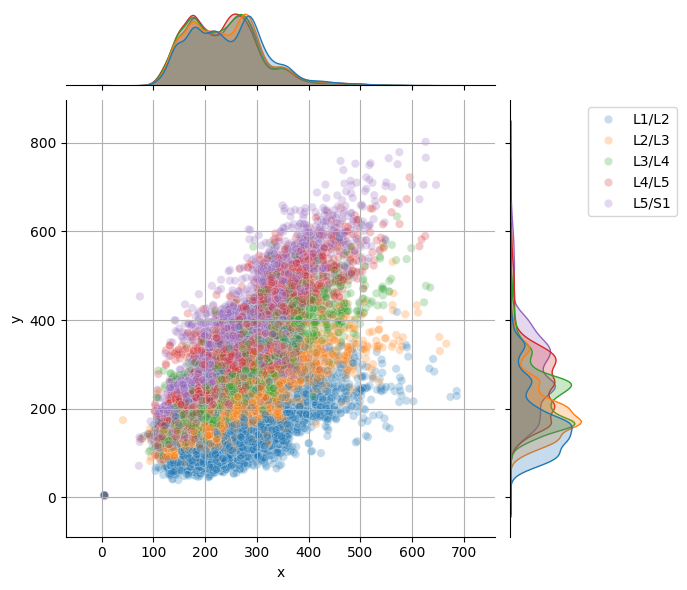

In [8]:
sns.jointplot(data=df, x='x', y='y', 
              hue='level', alpha=0.25)
plt.legend(bbox_to_anchor=(1.2,1), loc=2)
plt.grid()
plt.show()

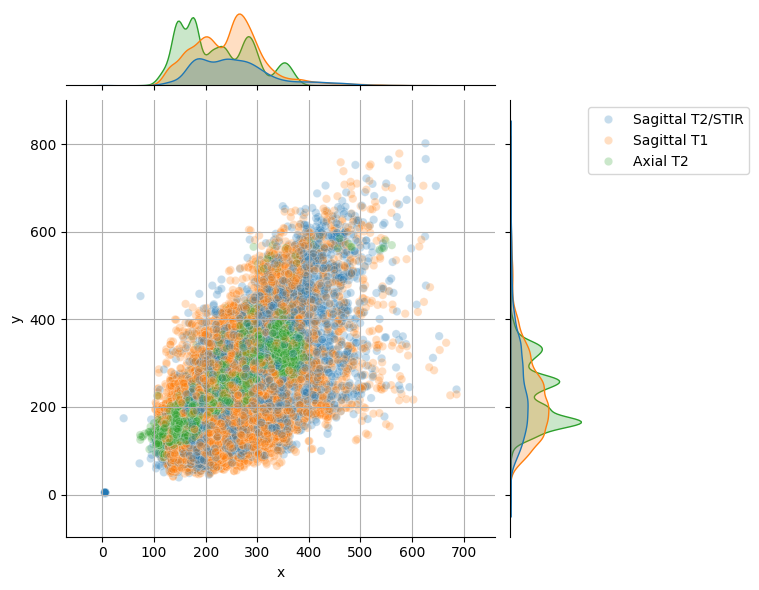

In [9]:
sns.jointplot(data=df, x='x', y='y', 
              hue='series_description', alpha=0.25)
plt.legend(bbox_to_anchor=(1.2,1), loc=2)
plt.grid()
plt.show()

In [10]:
part_1 = os.listdir('../data/train_images')
display(len(part_1))
# part_1 = list(filter(lambda x: x.find('.DS') == -1, part_1))
# display(len(part_1))

df_meta_f = pd.read_csv('../data/train_series_descriptions.csv')
display(df_meta_f.shape)
display(df_meta_f.head())

25

(6294, 3)

study_id   series_id series_description
0   4003253   702807833   Sagittal T2/STIR
1   4003253  1054713880        Sagittal T1
2   4003253  2448190387           Axial T2
3   4646740  3201256954           Axial T2
4   4646740  3486248476        Sagittal T1

In [11]:
first_key = part_1[0]
display(first_key)
p1 = [(x, f'../data/train_images/{x}') for x in part_1]
# display(type(p1))
display(p1[0])

meta_obj = {p[0]: {'folder_path': p[1], 
                   'SeriesInstanceUIDs': os.listdir(p[1]),
                   'SeriesDescriptions': []}
            for p in p1}
# display(type(meta_obj))
# display(meta_obj)
# display(len(meta_obj))
display(meta_obj[first_key]['SeriesInstanceUIDs'])

# for m in meta_obj:
# #     display(m)
# #     meta_obj[m]['SeriesInstanceUIDs'] = list(filter(lambda x: x.find('.DS') == -1, os.listdir(meta_obj[m]['folder_path'])))
#     meta_obj[m]['SeriesInstanceUIDs'] = os.listdir(meta_obj[m]['folder_path'])
# # display(meta_obj)
# display(len(meta_obj))

'10728036'

('10728036', '../data/train_images/10728036')

['142859125', '2073726394', '2399638375', '3491739931']

In [12]:
for k in meta_obj:
    for s in meta_obj[k]['SeriesInstanceUIDs']:
        try: #https://www.w3schools.com/python/python_try_except.asp
            meta_obj[k]['SeriesDescriptions'].append(df_meta_f[(df_meta_f['study_id'] == int(k)) & 
                (df_meta_f['series_id'] == int(s))]['series_description'].iloc[0])
        except:
            print("Failed on", s, k)

In [13]:
display(meta_obj[first_key]['SeriesInstanceUIDs'])
display(meta_obj[first_key]['SeriesDescriptions'])
display(meta_obj[list(meta_obj.keys())[0]])

['142859125', '2073726394', '2399638375', '3491739931']

['Axial T2', 'Axial T2', 'Sagittal T1', 'Sagittal T2/STIR']

{'folder_path': '../data/train_images/10728036',
 'SeriesInstanceUIDs': ['142859125', '2073726394', '2399638375', '3491739931'],
 'SeriesDescriptions': ['Axial T2',
  'Axial T2',
  'Sagittal T1',
  'Sagittal T2/STIR']}

In [14]:
patient = train_df.iloc[1]
ptobj = meta_obj[str(patient['study_id'])]
display(ptobj)

{'folder_path': '../data/train_images/4646740',
 'SeriesInstanceUIDs': ['3201256954', '3486248476', '3666319702'],
 'SeriesDescriptions': ['Axial T2', 'Sagittal T1', 'Sagittal T2/STIR']}

In [15]:
im_list_dcm = {}
for idx, i in enumerate(ptobj['SeriesInstanceUIDs']):
    im_list_dcm[i] = {'images': [], 'description': ptobj['SeriesDescriptions'][idx]}
    images = glob.glob(f"{ptobj['folder_path']}/{ptobj['SeriesInstanceUIDs'][idx]}/*.dcm") #https://docs.python.org/3/library/glob.html
    # display(images)
    for j in sorted(images, key=lambda x: int(x.replace('\\','/').split('/')[-1].replace('.dcm', ''))):
        im_list_dcm[i]['images'].append({'SOPInstanceUID': j.replace('\\','/').split('/')[-1].replace('.dcm', ''), 'dicom': pydicom.dcmread(j)})

In [16]:
display(im_list_dcm[list(im_list_dcm.keys())[0]]['images'][0]['dicom'])
# display(im_list_dcm[list(im_list_dcm.keys())[0]]['images'][0]['dicom'].pixel_array)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 4646740.1.1
(0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.2'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 4646740.1.1
(0008, 0023) Content Date                        DA: '20240503'
(0008, 0033) Content Time                        TM: '223732.661374'
(0008, 103e) Series Description                  LO: ''
(0010, 0020) Patient ID                          LO: '4646740'
(0018, 0050) Slice Thickness                     DS: '4.0'
(0018, 0088) Spacing Between Slices              DS: '4.4'
(0018, 5100) Patient Position                    C

In [17]:
def display_images(images, title, max_images_per_row=4):
    num_images = len(images)
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row
    fig, axes = plt.subplots(num_rows, max_images_per_row, figsize=(5, 1.5 * num_rows))
    
    if num_rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for idx, image in enumerate(images):
        ax = axes[idx]
        ax.imshow(image, cmap='gray')
        ax.axis('off')
    
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()

In [18]:
# for i in im_list_dcm:
#     #https://pydicom.github.io/pydicom/dev/reference/generated/pydicom.pixels.pixel_array.html
#     if im_list_dcm[i]['description'] == 'Axial T2':
#         display_images([x['dicom'].pixel_array for x in im_list_dcm[i]['images']], im_list_dcm[i]['description'])

In [19]:
df_coor = pd.read_csv('../data/train_label_coordinates.csv')
display(df_coor.shape)
display(df_coor.head())

(48692, 7)

study_id  series_id  instance_number              condition  level  \
0   4003253  702807833                8  Spinal Canal Stenosis  L1/L2   
1   4003253  702807833                8  Spinal Canal Stenosis  L2/L3   
2   4003253  702807833                8  Spinal Canal Stenosis  L3/L4   
3   4003253  702807833                8  Spinal Canal Stenosis  L4/L5   
4   4003253  702807833                8  Spinal Canal Stenosis  L5/S1   

            x           y  
0  322.831858  227.964602  
1  320.571429  295.714286  
2  323.030303  371.818182  
3  335.292035  427.327434  
4  353.415929  483.964602

In [20]:
def display_coor_on_img(c, i, title):
    center_coordinates = (int(c['x']), int(c['y']))
    radius = 10
    color = (255, 0, 0)
    thickness = 2
    IMG = i['dicom'].pixel_array
    
    #https://www.geeksforgeeks.org/normalize-an-image-in-opencv-python/
    IMG_normalized = cv2.normalize(IMG, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    IMG_with_circle = cv2.circle(IMG_normalized.copy(), center_coordinates, radius, color, thickness)
    #https://zrruziev.medium.com/rgb-vs-bgr-relationships-between-color-depth-pixel-and-bytes-7821fa9c6320
    IMG_with_circle = cv2.cvtColor(IMG_with_circle, cv2.COLOR_BGR2RGB)
    
    plt.imshow(IMG_with_circle)
    plt.axis('off')
    plt.title(title)
    plt.show()

In [21]:
coor_entries = df_coor[df_coor['study_id'] == int(patient['study_id'])]
display(coor_entries.shape)
display(coor_entries.head())

(25, 7)

study_id   series_id  instance_number                    condition  level  \
25   4646740  3201256954               15  Right Subarticular Stenosis  L1/L2   
26   4646740  3201256954               16   Left Subarticular Stenosis  L1/L2   
27   4646740  3201256954               22   Left Subarticular Stenosis  L2/L3   
28   4646740  3201256954               22  Right Subarticular Stenosis  L2/L3   
29   4646740  3201256954               28  Right Subarticular Stenosis  L3/L4   

             x           y  
25  184.180995  263.239819  
26  235.317073  264.083624  
27  235.317073  254.717770  
28  200.977376  256.868778  
29  204.452489  252.814480

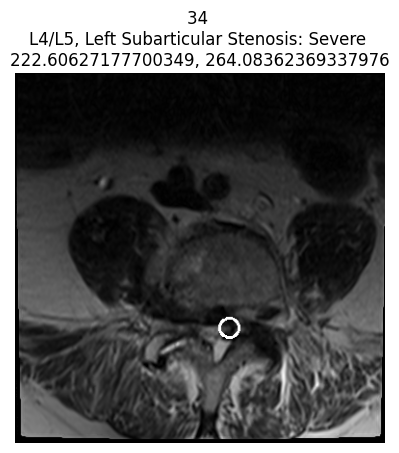

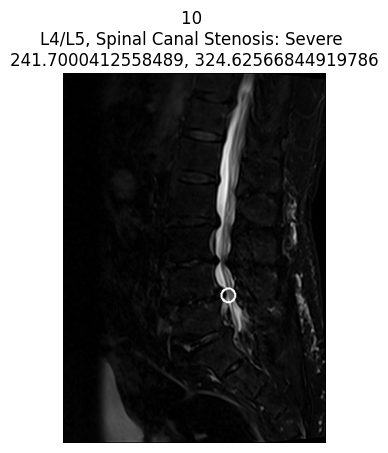

In [22]:
img_count = 0
for idc, c in coor_entries.iterrows(): #https://www.w3schools.com/python/pandas/ref_df_iterrows.asp
    # https://stackoverflow.com/questions/16476924/how-can-i-iterate-over-rows-in-a-pandas-dataframe
    for i in im_list_dcm[str(c['series_id'])]['images']:
        if int(i['SOPInstanceUID']) == int(c['instance_number']):
            try:
                patient_severity = patient[f"{c['condition'].lower().replace(' ', '_')}_{c['level'].lower().replace('/', '_')}"]
            except:
                patient_severity = "unknown severity"
            title = f"{i['SOPInstanceUID']} \n{c['level']}, {c['condition']}: {patient_severity} \n{c['x']}, {c['y']}"
            if patient_severity == 'Severe':
                display_coor_on_img(c, i, title)
            # display_coor_on_img(c, i, title)
            img_count = img_count + 1

In [23]:
display(img_count)

25

In [24]:
# https://www.kaggle.com/code/dschettler8845/rsna-lsdc-let-s-learn-together-eda/notebook
def get_img_stack(img_folder, plane, reverse_sort=False):
    img_data = [pydicom.dcmread(i) for i in glob.glob(os.path.join(img_folder, "*.dcm"))]
    plane_index = {"sagittal": 0, "coronal": 1, "axial": 2}[plane]
    positions = np.asarray([float(i.ImagePositionPatient[plane_index]) for i in img_data])
    idx = np.argsort(-positions if reverse_sort else positions)
    
    imgs = np.stack([i.pixel_array.astype("float32") for i in img_data])[idx]
    ipp = np.asarray([i.ImagePositionPatient for i in img_data]).astype("float")[idx]
    spacing = np.asarray(img_data[0].PixelSpacing).astype("float")
    return {"images": imgs, "positions": ipp, "pixel_spacing": spacing}

def map_axial_to_sagittal(sag_t2, ax_t2, plot_all_slices=False):
    top_left_hand_corner_sag_t2 = sag_t2["positions"][len(sag_t2["images"]) // 2]
    sag_y_axis_to_pixel_space = [top_left_hand_corner_sag_t2[2]]
    
    while len(sag_y_axis_to_pixel_space) < sag_t2["images"].shape[1]:
        sag_y_axis_to_pixel_space.append(sag_y_axis_to_pixel_space[-1] - sag_t2["pixel_spacing"][1])
    
    sag_y_coord_to_axial_slice = {}
    for ax_t2_slice, ax_t2_pos in zip(ax_t2["images"], ax_t2["positions"]):
        diffs = np.abs(np.asarray(sag_y_axis_to_pixel_space) - ax_t2_pos[2])
        sag_y_coord = np.argmin(diffs)
        sag_y_coord_to_axial_slice[sag_y_coord] = ax_t2_slice
    
    sag_midline_slice = sag_t2["images"][len(sag_t2["images"]) // 2]
    plt.imshow(sag_midline_slice, cmap="gray")
    
    for i in [*sag_y_coord_to_axial_slice]:
        plt.axhline(y=i, color="red", linestyle="--")
    plt.show()
    
    if plot_all_slices:
        for i, j in sag_y_coord_to_axial_slice.items():
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(sag_midline_slice, cmap="gray")
            plt.axhline(y=i, color="red", linestyle="--")
            plt.subplot(1, 2, 2)
            plt.imshow(j, cmap="gray")
            plt.show()

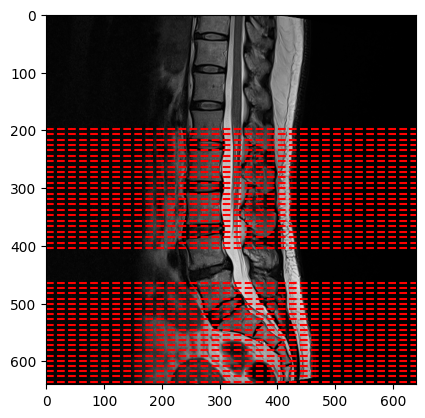

In [25]:
img_dir = "../data/train_images"
patient = desc_df.loc[desc_df.study_id == desc_df.study_id.iloc[1]]
ax_t2 = sag_t2 = None

for row in patient.itertuples():
    if row.series_description == "Sagittal T2/STIR":
        sag_t2 = get_img_stack(os.path.join(img_dir, str(row.study_id), str(row.series_id)), plane="sagittal")
    elif row.series_description == "Axial T2":
        ax_t2 = get_img_stack(os.path.join(img_dir, str(row.study_id), str(row.series_id)), plane="axial", reverse_sort=True)
    if sag_t2 and ax_t2:
        break

map_axial_to_sagittal(sag_t2, ax_t2)

In [26]:
def get_img_list(img_dict,series_instance_uid):
    imgs = [x['dicom'].pixel_array for x in img_dict[series_instance_uid]['images']]
    return np.stack(imgs,axis=-1)

# https://www.kaggle.com/code/satyaprakashshukl/rsna-lumbar-spine-analysis
def plot_3d_interactive(imgs, threshold=-300):
    verts, faces, idc, idc_2 = measure.marching_cubes(imgs, level=threshold)
    fig = go.Figure(data=[go.Mesh3d(x=verts[:, 0],
                                    y=verts[:, 1],
                                    z=verts[:, 2],
                                    i=faces[:, 0],
                                    j=faces[:, 1],
                                    k=faces[:, 2],
                                    color='blue',
                                    opacity=0.1)])
    fig.update_layout(scene=dict(xaxis=dict(visible=True),
                                 yaxis=dict(visible=True),
                                 zaxis=dict(visible=True)),
                            width=800,
                            height=800,
                            title="Interactive 3D Image Visualization")
    fig.show()

In [27]:
img_list = get_img_list(im_list_dcm, '3201256954')
# plot_3d_interactive(img_list, threshold=100)